In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [2]:
def filter1(image, median_size=3, gaussian_sigma=1):
    image = cv2.medianBlur(image, median_size)
    image = cv2.GaussianBlur(image, (0, 0), gaussian_sigma)
    return image

def filter2(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.bilateralFilter(image, 9, 75, 75)
    return image

def filter3(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.fastNlMeansDenoisingColored(image)
    return image

In [3]:
# Splits the given rect in 4 rect if there are at least k points inside 
def split_rect(rect, points, k=5, max_depth=5):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    max_depth -= 1
    if max_depth == 0:
        return []
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth)
        
        if len(upper_right_split) > 0:
            rects += upper_right_split
        else:
            rects += [upper_right_rect]
            
        if len(upper_left_split) > 0:
            rects += upper_left_split
        else:
            rects += [upper_left_rect]
            
        if len(lower_left_split) > 0:
            rects += lower_left_split
        else:
            rects += [lower_left_rect]
            
        if len(lower_right_split) > 0:
            rects += lower_right_split
        else:
            rects += [lower_right_rect]
         
            
    return rects

In [4]:
def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1

    return [s for s in template_partition if match_count[s] > 0]
    # return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

In [15]:
template = cv2.imread("./dataset/models/ref1.png")
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

scene = cv2.imread("./dataset/scenes/scene1.png")
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene = filter1(scene)

In [16]:
# sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()

kp_template = sift.detect(template)
kp_template, desc_template = sift.compute(template, kp_template)

kp_scene = sift.detect(scene)
kp_scene, desc_scene = sift.compute(scene, kp_scene)


FLANN_INDEX_KDTREE = 1

flann = cv2.FlannBasedMatcher(
    indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
    searchParams = { "checks": 50 }
)
matches = flann.knnMatch(desc_template, desc_scene, k=2)
good_matches = [ m for m, n in matches if m.distance < 0.7*n.distance ]

template_pts = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
scene_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)

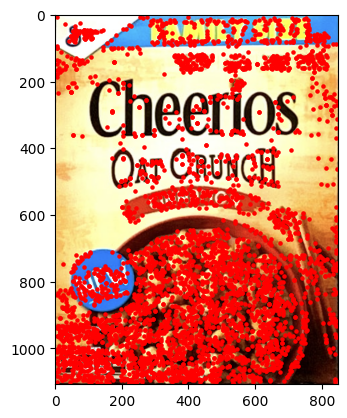

In [27]:
plt.imshow(template)
plt.scatter([k.pt[0] for k in kp_template], [k.pt[1] for k in kp_template], c="r", s=5)

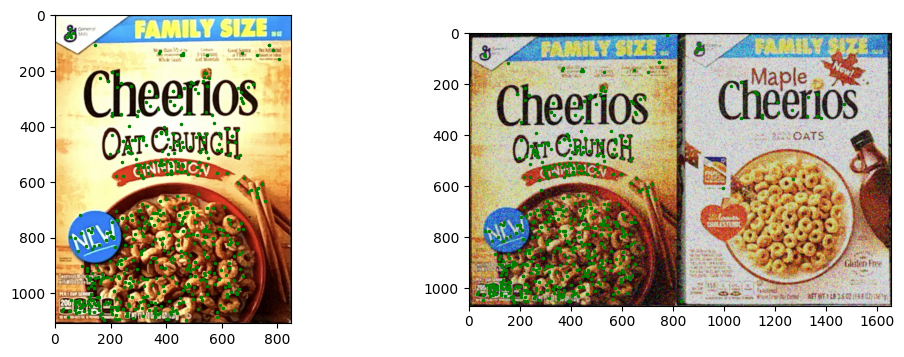

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(template)
plt.plot(template_pts[:, 0], template_pts[:, 1], "g.", markersize=3)

plt.subplot(1, 2, 2)
plt.imshow(scene)
plt.plot(scene_pts[:, 0], scene_pts[:, 1], "g.", markersize=3)
plt.show()

In [32]:
w, h, _ = template.shape
rects = split_rect(
    ( (h, w), (0, w), (0, 0), (h, 0) ),
    [ (kp.pt[0], kp.pt[1]) for kp in kp_template ],
    k = 3,
    max_depth = 6
)

match_rects = getDensity(template_pts, rects)

print(f"Confidence: {len(match_rects) / len(rects)}")

Confidence: 0.387409200968523


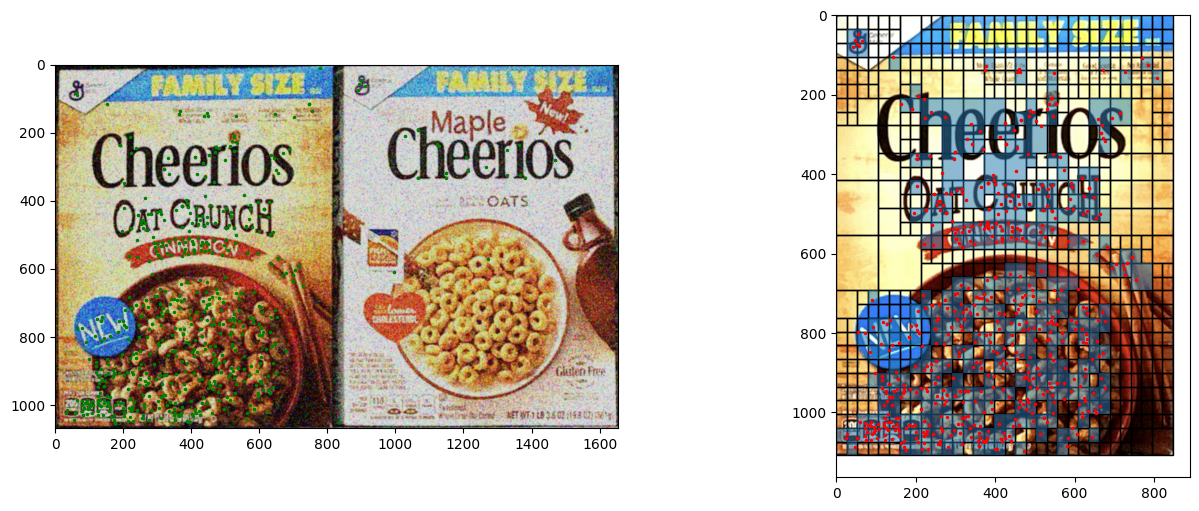

In [33]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(scene)
plt.plot(scene_pts[:, 0], scene_pts[:, 1], "g.", markersize=3)

ax = plt.subplot(1, 2, 2)
ax.imshow(template)
# ax.plot([kp.pt[0] for kp in kp_template], [kp.pt[1] for kp in kp_template], ".")
ax.plot([kp[0] for kp in template_pts], [kp[1] for kp in template_pts], "r.", markersize=3)
for r in rects:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=False))
for r in match_rects:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.5))

plt.show()

In [91]:
def get_confidence_match(template, scene, k=5, max_depth=5):
    sift = cv2.SIFT_create()

    kp_template = sift.detect(template)
    kp_template, desc_template = sift.compute(template, kp_template)

    kp_scene = sift.detect(scene)
    kp_scene, desc_scene = sift.compute(scene, kp_scene)


    FLANN_INDEX_KDTREE = 1

    flann = cv2.FlannBasedMatcher(
        indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
        searchParams = { "checks": 50 }
    )
    matches = flann.knnMatch(desc_template, desc_scene, k=2)
    good_matches = [ m for m, n in matches if m.distance < 0.7*n.distance ]

    template_pts = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
    scene_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)
    
    w, h, _ = template.shape
    rects = split_rect(
        ( (h, w), (0, w), (0, 0), (h, 0) ),
        [ (kp.pt[0], kp.pt[1]) for kp in kp_template ],
        k = k,
        max_depth = max_depth
    )

    match_rects = getDensity(template_pts, rects)
    
    return len(match_rects) / len(rects)
    # print(f"Confidence: {len(match_rects) / len(rects)}")

In [29]:
template = cv2.imread("./dataset/models/ref1.png")
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

scene = cv2.imread("./dataset/scenes/scene1.png")
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene = filter1(scene)

In [31]:
get_confidence_match(template, scene, k=4, depth=4)

0.6141078838174274

In [92]:
from tqdm import tqdm

model_scenes_ground_truth = {
    "ref1" : ["scene1", "scene4"],
    "ref2" : ["scene1"],
    "ref3" : ["scene2"],
    "ref4" : ["scene2"]
}

all_scenes = [f"scene{i}" for i in range(1, 5)]
all_templates = [f"ref{i}" for i in range(1, 4)]

# Read all the scenes and all the templates
scenes = { s : cv2.imread(f"./dataset/scenes/{s}.png") for s in all_scenes }
templates = { t : cv2.imread(f"./dataset/models/{t}.png") for t in all_templates }

# Filter the scenes
scenes = { s : filter1(scenes[s]) for s in scenes }

# Get the confidence with different values for k and depth
kk = np.arange(2, 7)
depths = np.arange(2, 7)
confidences_correct = np.zeros((len(kk), len(depths), len(all_templates), len(all_scenes)))
confidences_wrong = np.zeros((len(kk), len(depths), len(all_templates), len(all_scenes)))

# I want to get the average confidence for each pair scene-template
for i, k in tqdm(enumerate(kk), total=len(kk), desc="k"):
    for j, depth in tqdm(enumerate(depths), total=len(depths), desc="depth"):
        # For each pair scene-template
        for t in all_templates:
            for s in all_scenes:
                # Get the confidence
                confidence = get_confidence_match(templates[t], scenes[s], k=k, max_depth=depth)
                # If the scene is in the ground truth
                if s in model_scenes_ground_truth[t]:
                    confidences_correct[i, j, all_templates.index(t), all_scenes.index(s)] = confidence
                else:
                    confidences_wrong[i, j, all_templates.index(t), all_scenes.index(s)] = confidence
                
                
            
        

k: 100%|██████████| 5/5 [05:07<00:00, 61.54s/it]


In [98]:
confidences_correct_mean = np.mean(confidences_correct, axis=(2, 3), where=confidences_correct > 0)

In [99]:
confidences_correct_mean

array([[1.        , 0.984375  , 0.8046875 , 0.52771937, 0.29705383],
       [1.        , 0.96875   , 0.8125    , 0.53811336, 0.30576823],
       [1.        , 0.984375  , 0.79296875, 0.54866591, 0.32037115],
       [1.        , 0.984375  , 0.8046875 , 0.54296391, 0.33137129],
       [1.        , 0.96875   , 0.7890625 , 0.55390216, 0.34858447]])

In [100]:
confidences_wrong_mean = np.mean(confidences_wrong, axis=(2, 3), where=confidences_wrong > 0)

In [102]:
confidences_wrong_mean

array([[1.        , 0.65625   , 0.2734375 , 0.11007905, 0.03935415],
       [1.        , 0.671875  , 0.2734375 , 0.10938057, 0.04077742],
       [0.9375    , 0.671875  , 0.27929688, 0.11255612, 0.04251538],
       [0.96875   , 0.6484375 , 0.28320312, 0.11236482, 0.04613821],
       [0.96875   , 0.65625   , 0.27734375, 0.11484784, 0.04907007]])

In [104]:
confidences_correct_mean - confidences_wrong_mean

array([[0.        , 0.328125  , 0.53125   , 0.41764032, 0.25769968],
       [0.        , 0.296875  , 0.5390625 , 0.42873279, 0.26499081],
       [0.0625    , 0.3125    , 0.51367188, 0.43610979, 0.27785577],
       [0.03125   , 0.3359375 , 0.52148438, 0.43059908, 0.28523308],
       [0.03125   , 0.3125    , 0.51171875, 0.43905433, 0.2995144 ]])

In [93]:
import pandas as pd

# Reshape confidences_correct to have one row per combination of k, depth, template, and scene
reshaped_confidences = confidences_correct.reshape(-1, len(all_templates)*len(all_scenes))

# Create a list of tuples containing k, depth, scene, template, and confidence
data = []
for i, k in enumerate(kk):
    for j, depth in enumerate(depths):
        for s_index, s in enumerate(all_scenes):
            for t_index, t in enumerate(all_templates):
                data.append((k, depth, s, t, confidences_correct[i, j, t_index, s_index]))

# Create a DataFrame from the list of tuples
df_correct = pd.DataFrame(data, columns=["k", "depth", "scene", "template", "confidence"])

# Optionally, you can set "k", "depth", "scene", and "template" as categorical variables
df_correct["k"] = pd.Categorical(df_correct["k"])
df_correct["depth"] = pd.Categorical(df_correct["depth"])
df_correct["scene"] = pd.Categorical(df_correct["scene"])
df_correct["template"] = pd.Categorical(df_correct["template"])

# Display the DataFrame
# save df to csv
df_correct.to_csv("correct.csv", index=False)

In [67]:
import pandas as pd

# Reshape confidences_correct to have one row per combination of k, depth, template, and scene
reshaped_confidences = confidences_wrong.reshape(-1, len(all_templates)*len(all_scenes))

# Create a list of tuples containing k, depth, scene, template, and confidence
data = []
for i, k in enumerate(kk):
    for j, depth in enumerate(depths):
        for s_index, s in enumerate(all_scenes):
            for t_index, t in enumerate(all_templates):
                data.append((k, depth, s, t, confidences_wrong[i, j, t_index, s_index]))

# Create a DataFrame from the list of tuples
df_wrong = pd.DataFrame(data, columns=["k", "depth", "scene", "template", "confidence"])

# Optionally, you can set "k", "depth", "scene", and "template" as categorical variables
df_wrong["k"] = pd.Categorical(df_wrong["k"])
df_wrong["depth"] = pd.Categorical(df_wrong["depth"])
df_wrong["scene"] = pd.Categorical(df_wrong["scene"])
df_wrong["template"] = pd.Categorical(df_wrong["template"])

# Display the DataFrame
df_wrong

,k,depth,scene,template,confidence
0,2,2,scene1,ref1,0.000000
1,2,2,scene1,ref2,0.000000
2,2,2,scene1,ref3,0.081967
3,2,2,scene2,ref1,0.147059
4,2,2,scene2,ref2,0.163934
...,...,...,...,...,...
295,6,6,scene3,ref2,0.053279
296,6,6,scene3,ref3,0.131148
297,6,6,scene4,ref1,0.000000
298,6,6,scene4,ref2,0.159836


In [76]:
# Average the dataframe by eliminating scene and template, and averaging confidence
df_correct_avg = df_correct.groupby(["k", "depth","scene", "template"]).mean()
df_correct_avg

C:\Users\Luca\AppData\Local\Temp\ipykernel_1000\3961295294.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_correct_avg = df_correct.groupby(["k", "depth","scene", "template"]).mean()


confidence
k depth scene  template            
2 2     scene1 ref1        0.663866
               ref2        0.590164
               ref3        0.000000
        scene2 ref1        0.000000
               ref2        0.000000
...                             ...
6 6     scene3 ref2        0.000000
               ref3        0.000000
        scene4 ref1        0.508403
               ref2        0.000000
               ref3        0.000000

[300 rows x 1 columns]

In [47]:
i = 0
for i,k in tqdm(enumerate(range(100000000))):
    i += 1

52098428it [00:07, 6808872.40it/s]


KeyboardInterrupt: 